In [1]:
import pandas as pd
import numpy as np
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.simplefilter("ignore")

## HDBSCAN PCA

In [3]:
PCA_ds = pd.read_csv('data_reduccion_PCA.csv',sep=',')
PCA_ds.head()

,col1,col2,col3,col4,col5,col6
0,4.986336,-0.161519,2.445158,-0.177979,1.085071,-0.429372
1,-2.874168,0.022697,-1.530797,-1.401975,1.746937,0.577904
2,2.615763,-0.731417,-0.263984,-0.040425,-0.668800,0.539707
3,-2.654568,-1.455872,-0.398069,1.295974,0.315622,0.877846
4,-0.656015,0.177868,-0.141113,1.653062,0.259336,-0.936212


In [4]:
data = pd.read_csv('data_transformada_escalada.csv',sep=',')
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


In [5]:
min_cluster_sizes = [2,3,4,5, 10, 15, 20, 25]
min_samples_list = [None, 5, 10]

results = []

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_list:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = clusterer.fit_predict(PCA_ds)
        
        mask = labels != -1
        n_clusters = len(set(labels[mask]))
        
        if n_clusters > 1:
            score = silhouette_score(PCA_ds[mask], labels[mask])
        else:
            score = -1
        
        results.append({
            "min_cluster_size": min_cluster_size,
            "min_samples": min_samples if min_samples is not None else "auto",
            "n_clusters": n_clusters,
            "silhouette_score": round(score, 2)
        })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="silhouette_score", ascending=False).head())

    min_cluster_size min_samples  n_clusters  silhouette_score
21                25        auto           2              0.42
0                  2        auto         305              0.38
18                20        auto           8              0.31
15                15        auto          10              0.29
14                10          10          10              0.28


Silhouette Score con HDBSCAN: 0.42


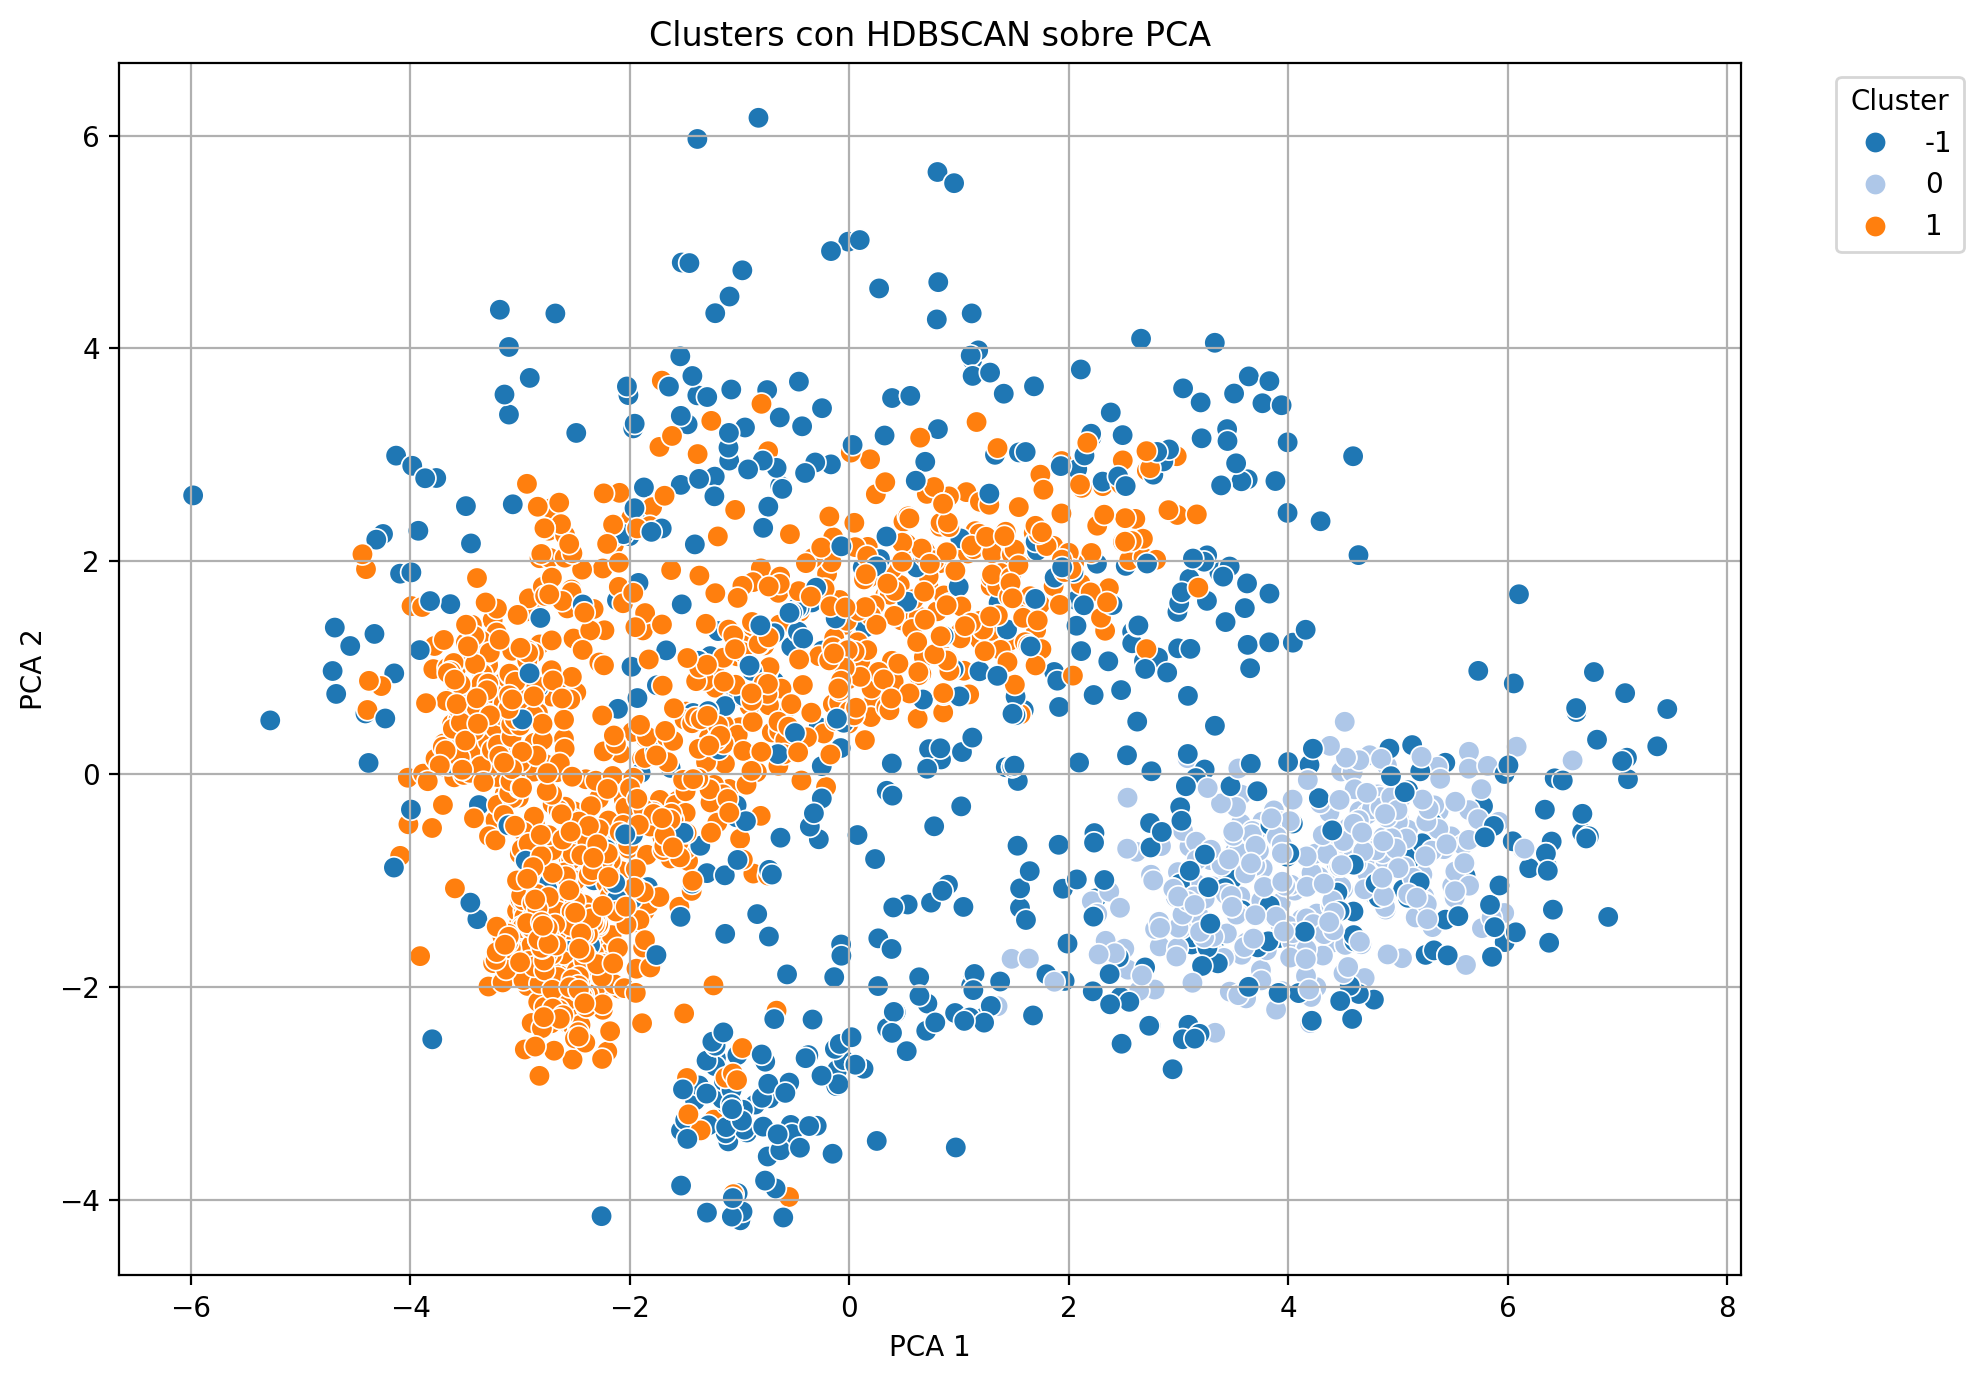

In [9]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=None)
labels_hdb = clusterer.fit_predict(PCA_ds)

mask = labels_hdb != -1
if len(set(labels_hdb[mask])) > 1:
    score = silhouette_score(PCA_ds[mask], labels_hdb[mask])
    print(f"Silhouette Score con HDBSCAN: {score:.2f}")
else:
    print("No hay suficientes clusters para calcular Silhouette Score.")

plt.figure(figsize=(10, 7))
sns.scatterplot(x=PCA_ds['col1'], y=PCA_ds['col2'], hue=labels_hdb, palette="tab20", s=60)
plt.title("Clusters con HDBSCAN sobre PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

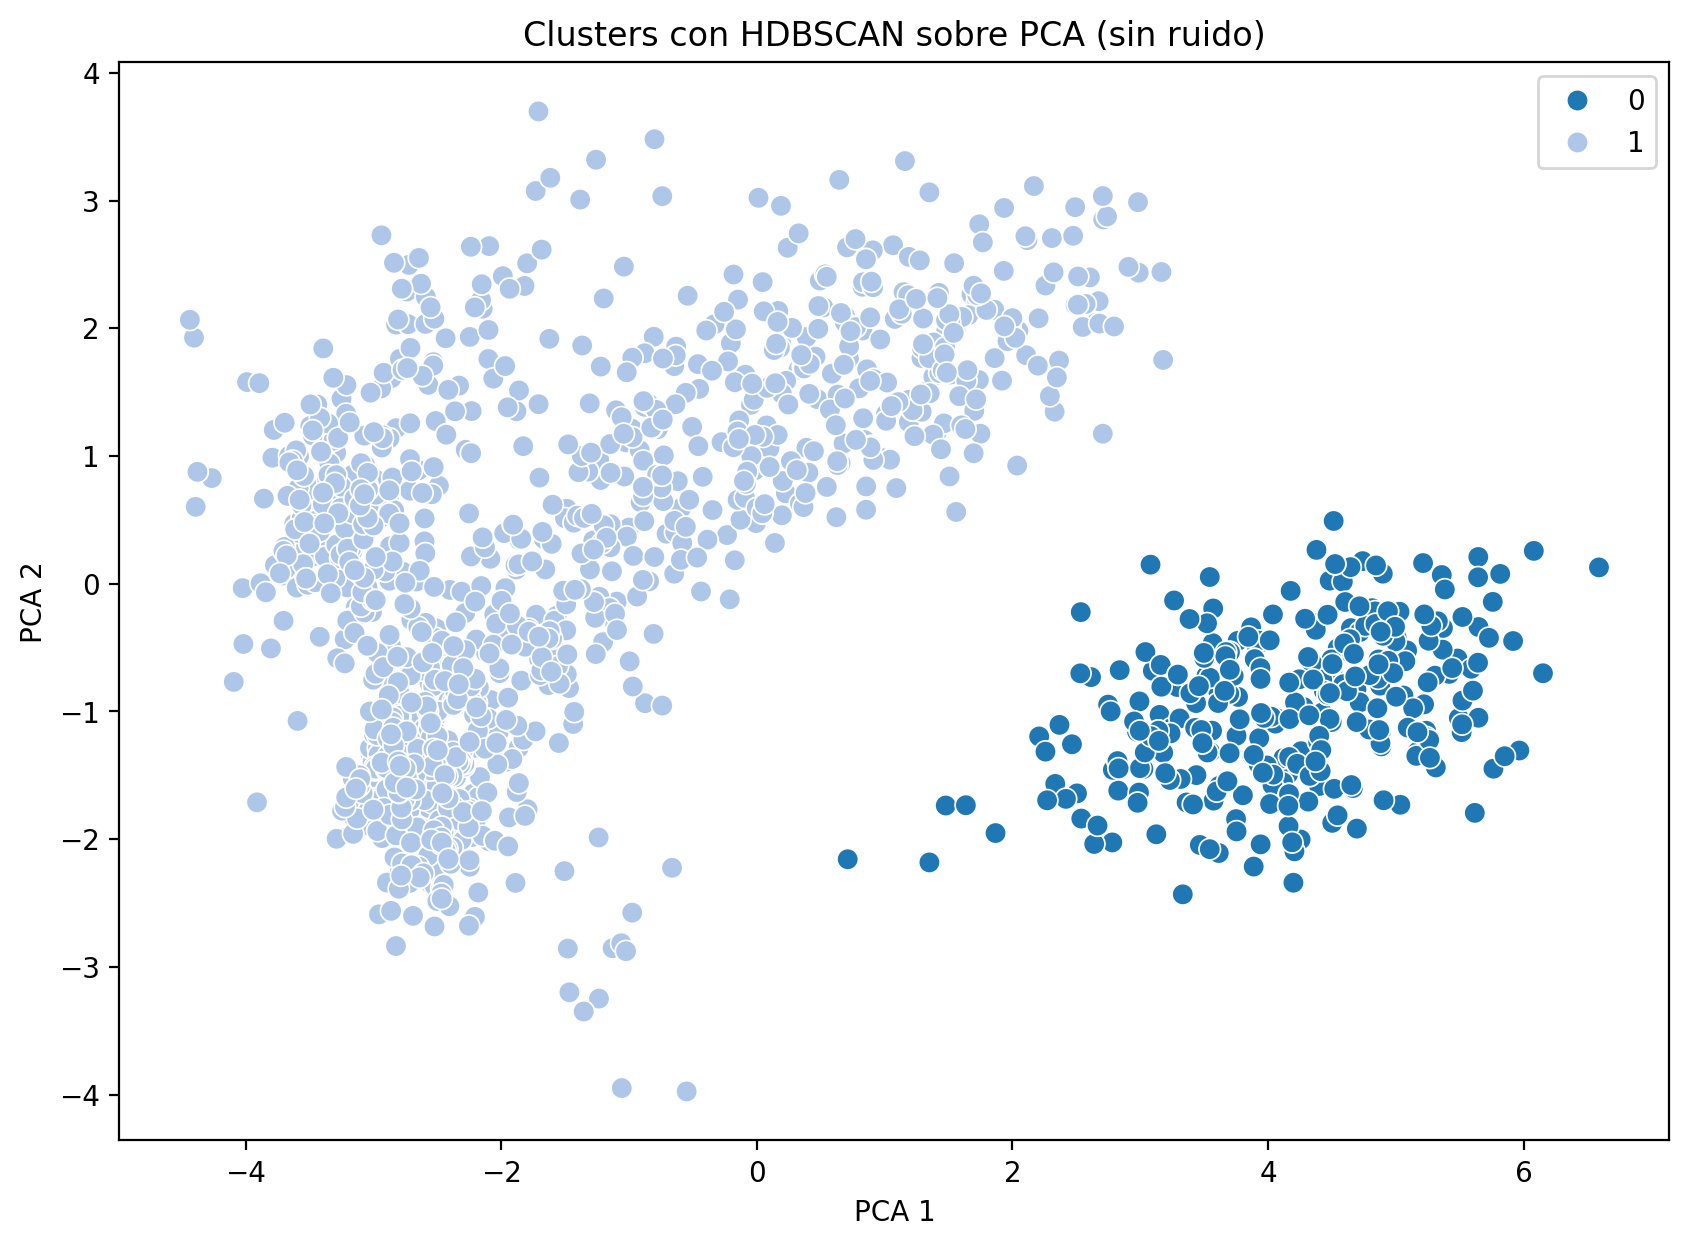

In [12]:
filtered_data = PCA_ds[labels_hdb != -1]
filtered_labels = labels_hdb[labels_hdb != -1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=filtered_data['col1'], 
    y=filtered_data['col2'], 
    hue=filtered_labels,        
    palette="tab20",            
    s=60                        
)
plt.title("Clusters con HDBSCAN sobre PCA (sin ruido)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

## HDBSCAN TSNE

In [13]:
TSNE_ds = pd.read_csv('data_reduccion_TSNE.csv',sep=',')
TSNE_ds.head()

,col1,col2
0,30.620274,-7.712108
1,-48.222248,12.715313
2,28.431597,-21.590351
3,-50.654060,-22.825716
4,-36.348347,-20.864601


In [14]:
data = pd.read_csv('data_transformada_escalada.csv',sep=',')
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


In [15]:
min_cluster_sizes = [2,3,4,5, 10, 15, 20, 25]
min_samples_list = [None, 5, 10]

results = []

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_list:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = clusterer.fit_predict(TSNE_ds)
        
        mask = labels != -1
        n_clusters = len(set(labels[mask]))
        
        if n_clusters > 1:
            score = silhouette_score(TSNE_ds[mask], labels[mask])
        else:
            score = -1
        
        results.append({
            "min_cluster_size": min_cluster_size,
            "min_samples": min_samples if min_samples is not None else "auto",
            "n_clusters": n_clusters,
            "silhouette_score": round(score, 2)
        })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="silhouette_score", ascending=False).head())

    min_cluster_size min_samples  n_clusters  silhouette_score
0                  2        auto         348              0.49
21                25        auto          11              0.48
18                20        auto          12              0.45
23                25          10          14              0.44
22                25           5          14              0.41


Silhouette Score con HDBSCAN: 0.48


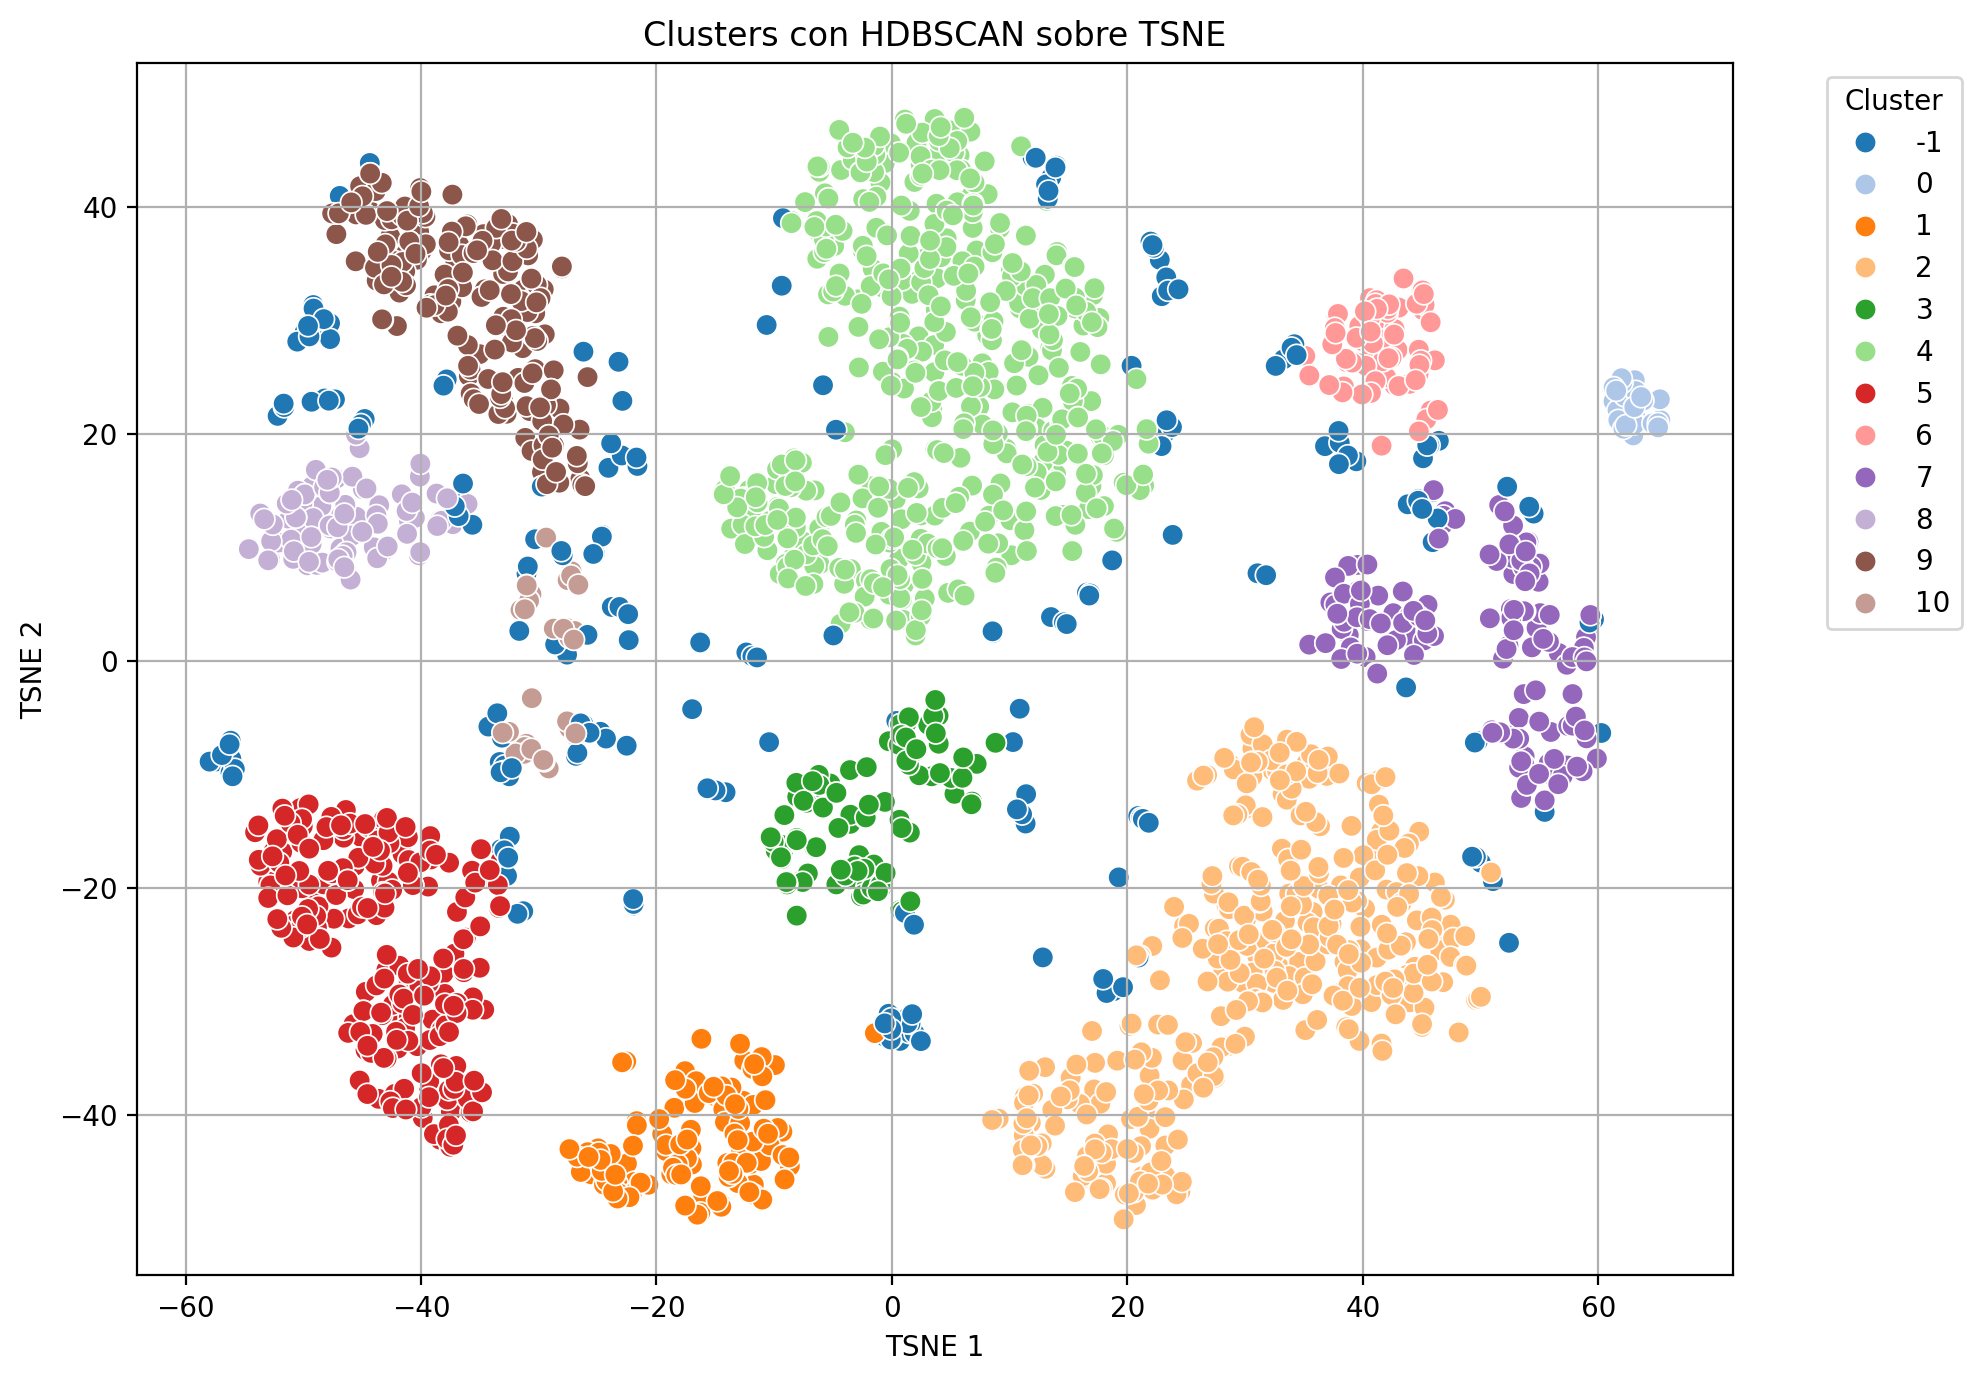

In [17]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=None)
labels_hdb = clusterer.fit_predict(TSNE_ds)

mask = labels_hdb != -1
if len(set(labels_hdb[mask])) > 1:
    score = silhouette_score(TSNE_ds[mask], labels_hdb[mask])
    print(f"Silhouette Score con HDBSCAN: {score:.2f}")
else:
    print("No hay suficientes clusters para calcular Silhouette Score.")

plt.figure(figsize=(10, 7))
sns.scatterplot(x=TSNE_ds['col1'], y=TSNE_ds['col2'], hue=labels_hdb, palette="tab20", s=60)
plt.title("Clusters con HDBSCAN sobre TSNE")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

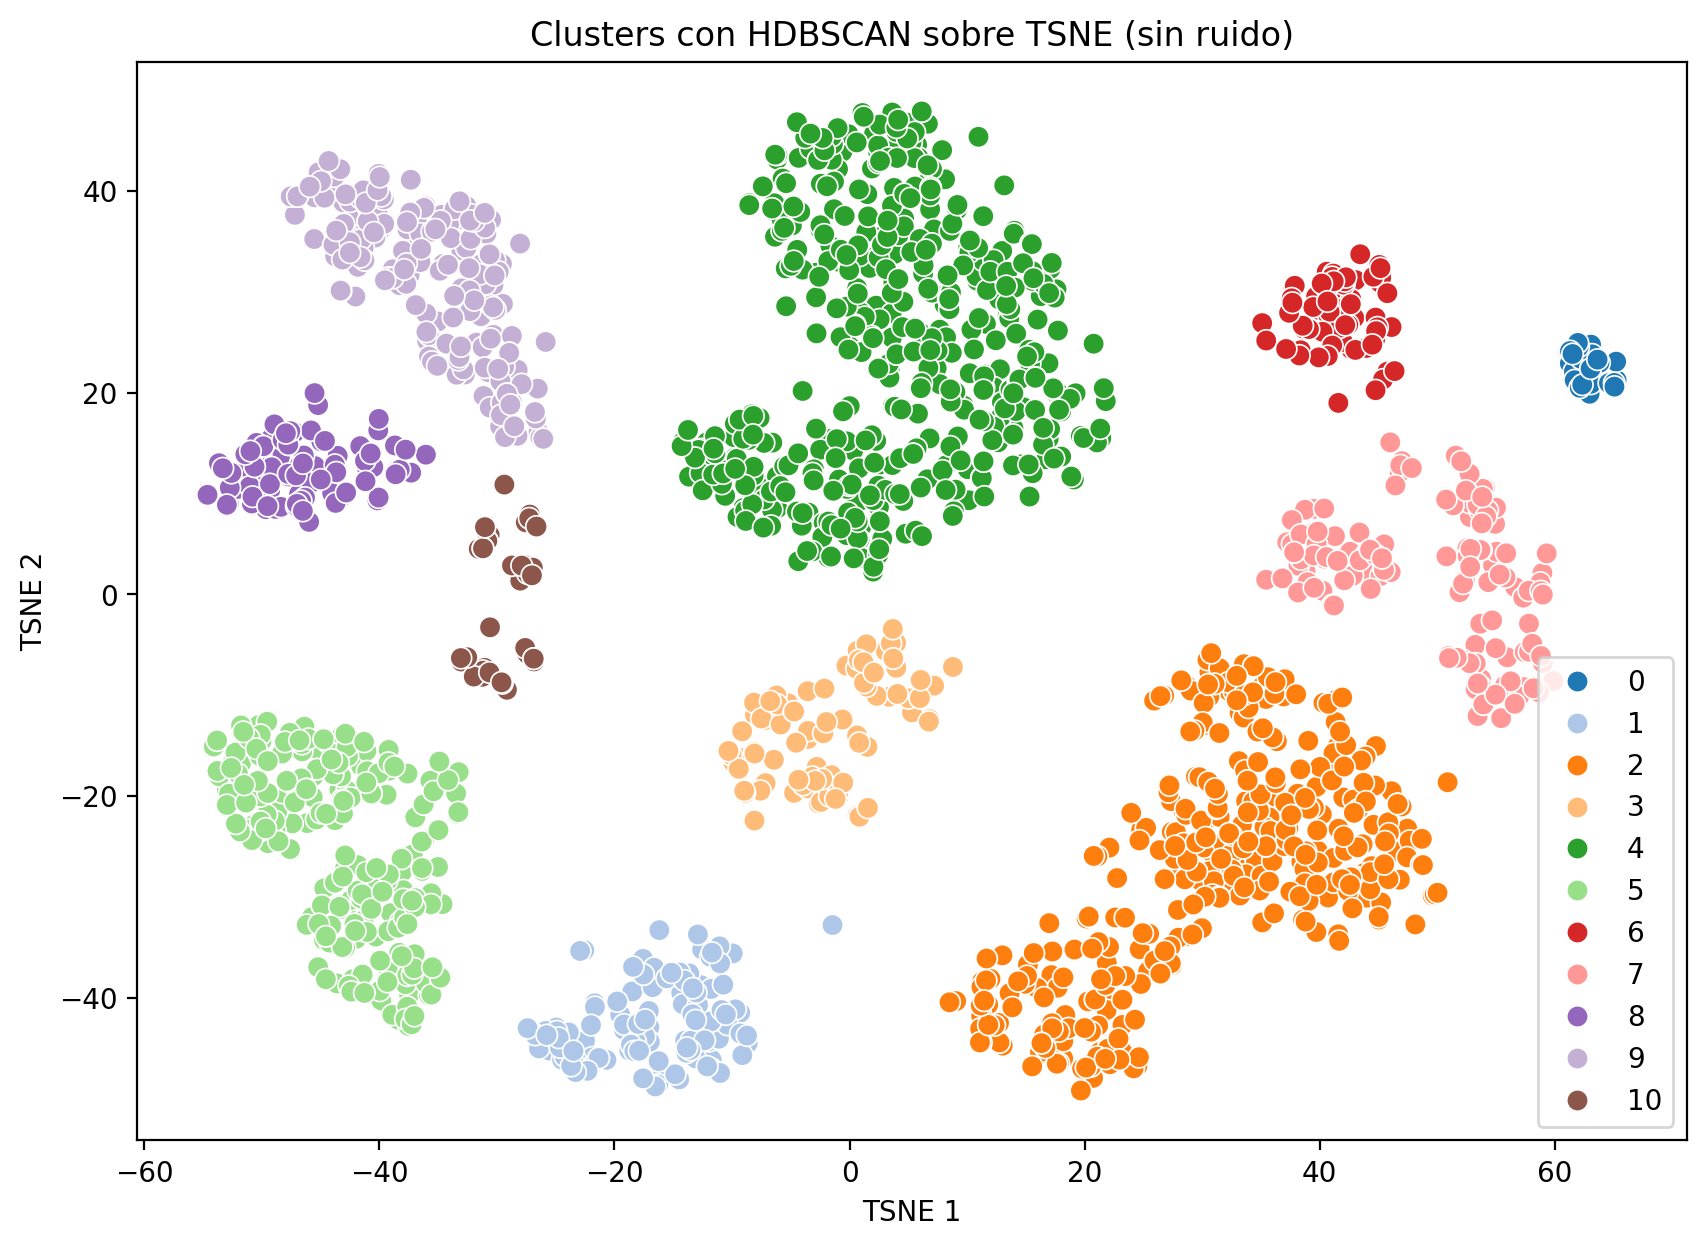

In [18]:
filtered_data = TSNE_ds[labels_hdb != -1]
filtered_labels = labels_hdb[labels_hdb != -1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=filtered_data['col1'], 
    y=filtered_data['col2'], 
    hue=filtered_labels,        
    palette="tab20",            
    s=60                        
)
plt.title("Clusters con HDBSCAN sobre TSNE (sin ruido)")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()

## HDBSCAN UMAP

In [20]:
UMAP_ds = pd.read_csv('data_reduccion_UMAP.csv',sep=',')
UMAP_ds.head()

,col1,col2
0,7.947662,12.219968
1,11.329375,-0.086987
2,5.836195,12.522989
3,6.380645,-6.642157
4,8.008347,-6.492001


In [21]:
data = pd.read_csv('data_transformada_escalada.csv',sep=',')
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


In [22]:
min_cluster_sizes = [2,3,4,5, 10, 15, 20, 25]
min_samples_list = [None, 5, 10]

results = []

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_list:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = clusterer.fit_predict(UMAP_ds)
        
        mask = labels != -1
        n_clusters = len(set(labels[mask]))
        
        if n_clusters > 1:
            score = silhouette_score(UMAP_ds[mask], labels[mask])
        else:
            score = -1
        
        results.append({
            "min_cluster_size": min_cluster_size,
            "min_samples": min_samples if min_samples is not None else "auto",
            "n_clusters": n_clusters,
            "silhouette_score": round(score, 2)
        })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="silhouette_score", ascending=False).head())

    min_cluster_size min_samples  n_clusters  silhouette_score
21                25        auto          12              0.68
18                20        auto          13              0.68
15                15        auto          16              0.68
11                 5          10          30              0.67
2                  2          10          30              0.67


Silhouette Score con HDBSCAN: 0.68


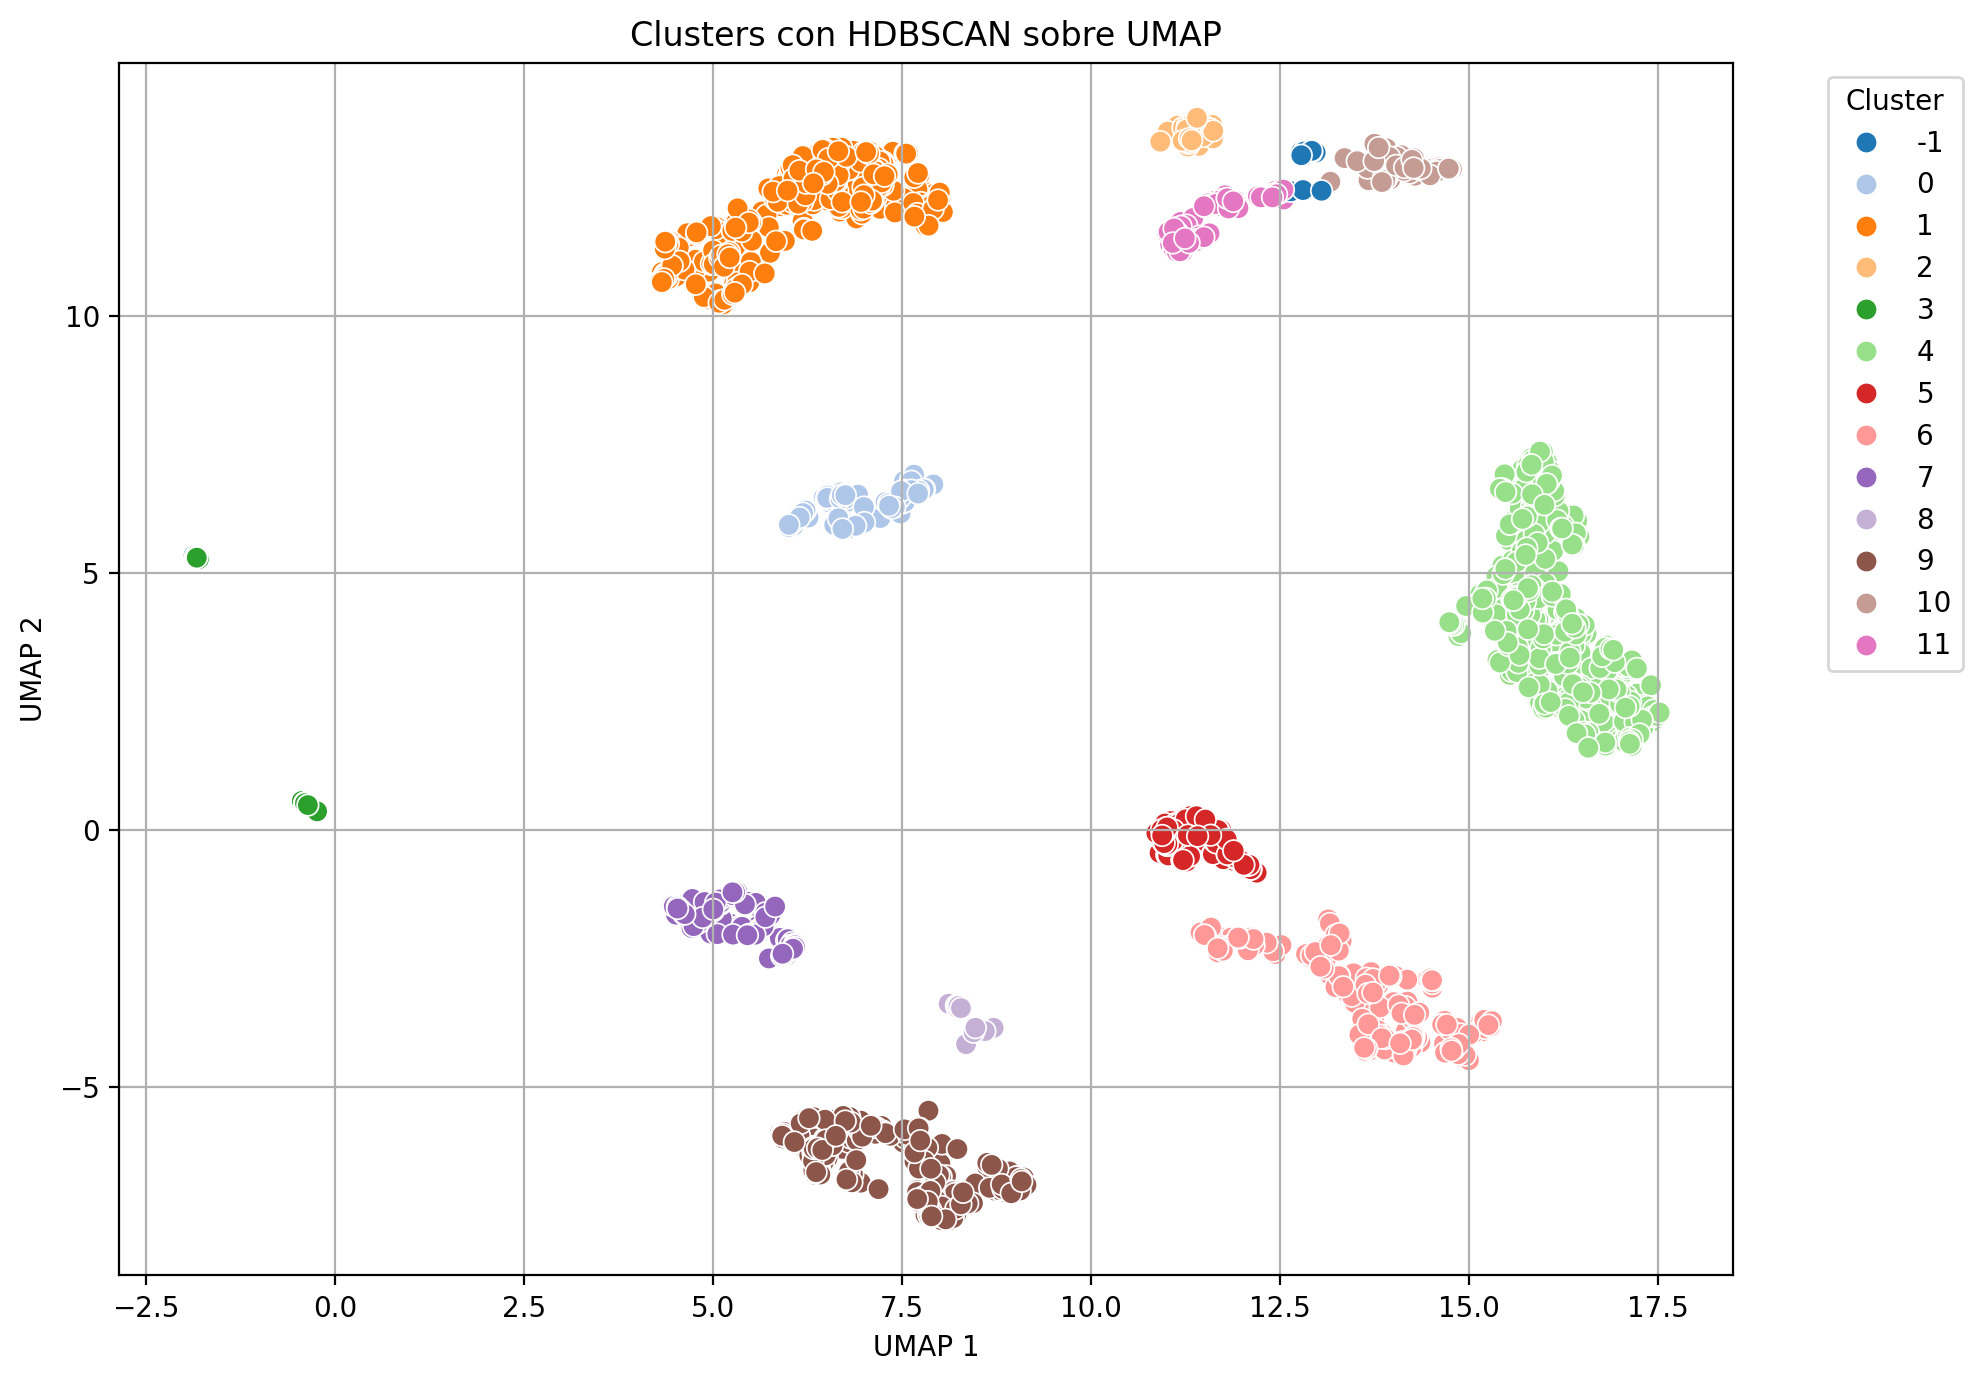

In [23]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=None)
labels_hdb = clusterer.fit_predict(UMAP_ds)

mask = labels_hdb != -1
if len(set(labels_hdb[mask])) > 1:
    score = silhouette_score(UMAP_ds[mask], labels_hdb[mask])
    print(f"Silhouette Score con HDBSCAN: {score:.2f}")
else:
    print("No hay suficientes clusters para calcular Silhouette Score.")

plt.figure(figsize=(10, 7))
sns.scatterplot(x=UMAP_ds['col1'], y=UMAP_ds['col2'], hue=labels_hdb, palette="tab20", s=60)
plt.title("Clusters con HDBSCAN sobre UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

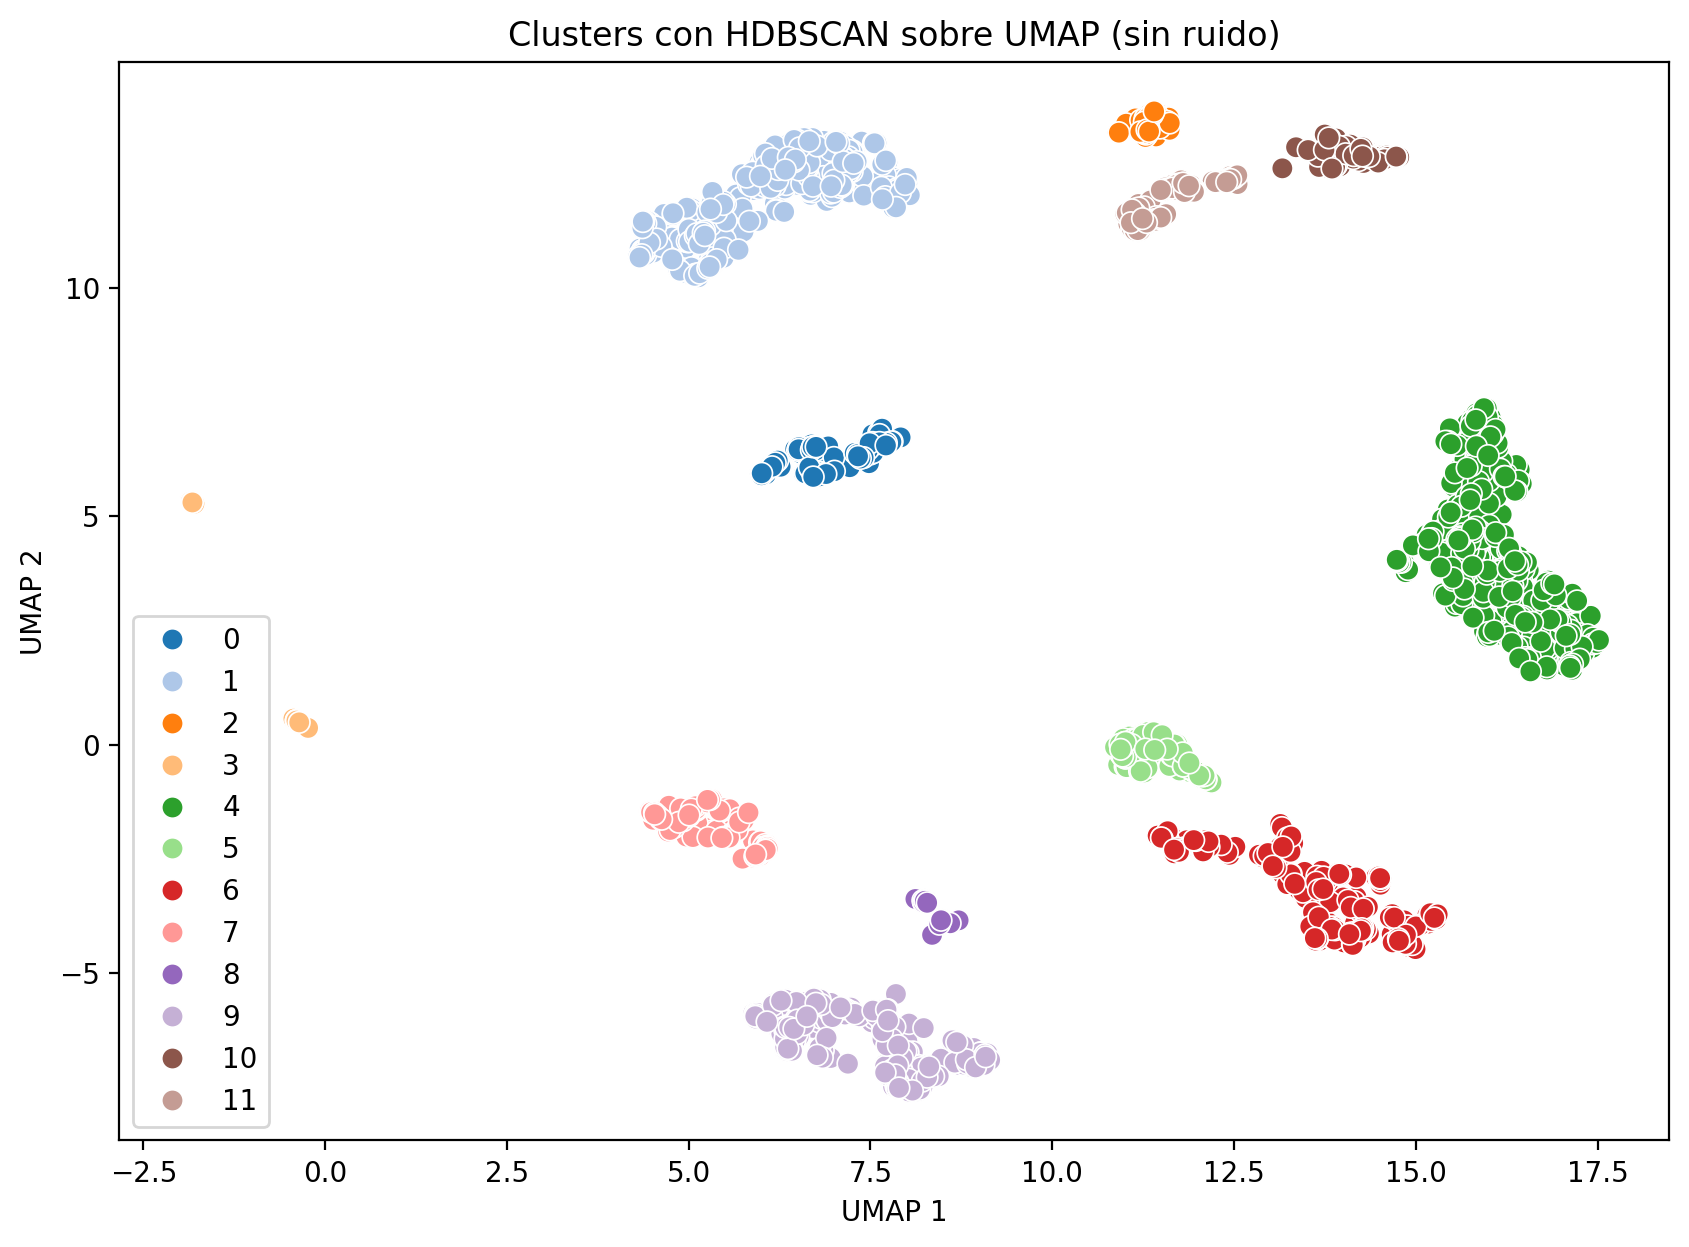

In [24]:
filtered_data = UMAP_ds[labels_hdb != -1]
filtered_labels = labels_hdb[labels_hdb != -1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=filtered_data['col1'], 
    y=filtered_data['col2'], 
    hue=filtered_labels,        
    palette="tab20",            
    s=60                        
)
plt.title("Clusters con HDBSCAN sobre UMAP (sin ruido)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()